In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import datetime
from plot_utils import get_experiments_results
from env_var import EPIDEMIC, MAPPINGS, EXPERIMENTS

mpl.rcParams['figure.dpi']= 175
plt.style.use('ggplot')

In [2]:
# Simulation parameters
erva_pop_file = 'stats/erva_population_age_2020.csv'

num_age_groups = EXPERIMENTS['num_age_groups']
num_ervas = EXPERIMENTS['num_ervas']
T = EXPERIMENTS['simulate_T']
init_vacc = EXPERIMENTS['init_vacc']
u = EXPERIMENTS['vaccines_per_day']
r_experiments = EXPERIMENTS['r_eff_experiments']
t0 = EXPERIMENTS['t0']

# Plot parameters
plot_interval = 15
ervas_labels = EPIDEMIC['ervas_order']
age_labels = MAPPINGS['age_groups'][number_age_groups]['names']

strategies = [
    ('equal', EPIDEMIC['ws_vacc'], 'equal'),
    ('no_vacc', EPIDEMIC['ws_vacc'], 'no vaccination'),
    ('thl', EPIDEMIC['ws_vacc'], 'THL Pop, inf, hosp'),
    ('thl', [1/2, 1/2, 0], 'THL Pop and hosp'),
    ('thl', [1/2, 0, 1/2], 'THL Pop and inf'),
    ('thl', [0, 1/2, 1/2], 'THL Hosp and inf'),
    ('thl', [0, 1, 0], 'THL Hosp only'),
    ('thl', [0, 0, 1], 'THL Inf only'),
]

In [3]:
def get_infections_r_eff(T, t0, mob_av, beta_gh, pop_erva_hat, age_er, *rs):
    age_er_prop = age_er.T
    age_er_prop = age_er_prop[:, :, np.newaxis]
    r_infs = []
    u = 0
    policy = 'no_vacc'
    total_rs = len(rs)
    for i, r in enumerate(rs):
        beta = r/rho
        _, e_g, _, _, i_r, _, _ = forward_integration(u, mob_av, beta, beta_gh, T, pop_erva_hat,
                                                    age_er, t0, policy, init_vacc=init_vacc)
        
        i_r_plot = i_r*age_er_prop
        e_g_plot = e_g*age_er_prop
        result_r = ('R=%s' % (r, ), i_r_plot, e_g_plot)
        r_infs.append(result_r)
        print('Finished %s/%s. R: %f. Beta: %f' % (i+1, total_rs, r, beta), end='\r')
        
    return r_infs

In [4]:
init_vacc = True
mob_av, beta_gh, pop_erva_hat, age_er, rho = get_model_parameters(number_age_groups, num_ervas, erva_pop_file, init_vacc, t0)
r_infs = get_infections_r_eff(T, t0, mob_av, beta_gh, pop_erva_hat, age_er, 0.9, 1.1, 1.0)

In [5]:
def compare_rs_curves(ax, t0, T, *r_infs):
    begin = datetime.datetime.strptime(t0, '%Y-%m-%d')
    x = [begin + datetime.timedelta(days=day) for day in range(T)]
    
    r_infs = r_infs[0]
    for label, infs, exps in r_infs:
        inf_plot = infs.sum(axis=1)
        inf_plot = inf_plot.sum(axis=0)
        
        exp_plot = exps.sum(axis=1)
        exp_plot = exp_plot.sum(axis=0)
        
        assert inf_plot.shape[0] == T
        
        ax.plot(x, inf_plot, label=label)
#         ax.plot(x, exp_plot, label=label + 'E')
        
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of infections')
    ax.set_title('Comparing Rs')
    ax.legend()
    
    return ax

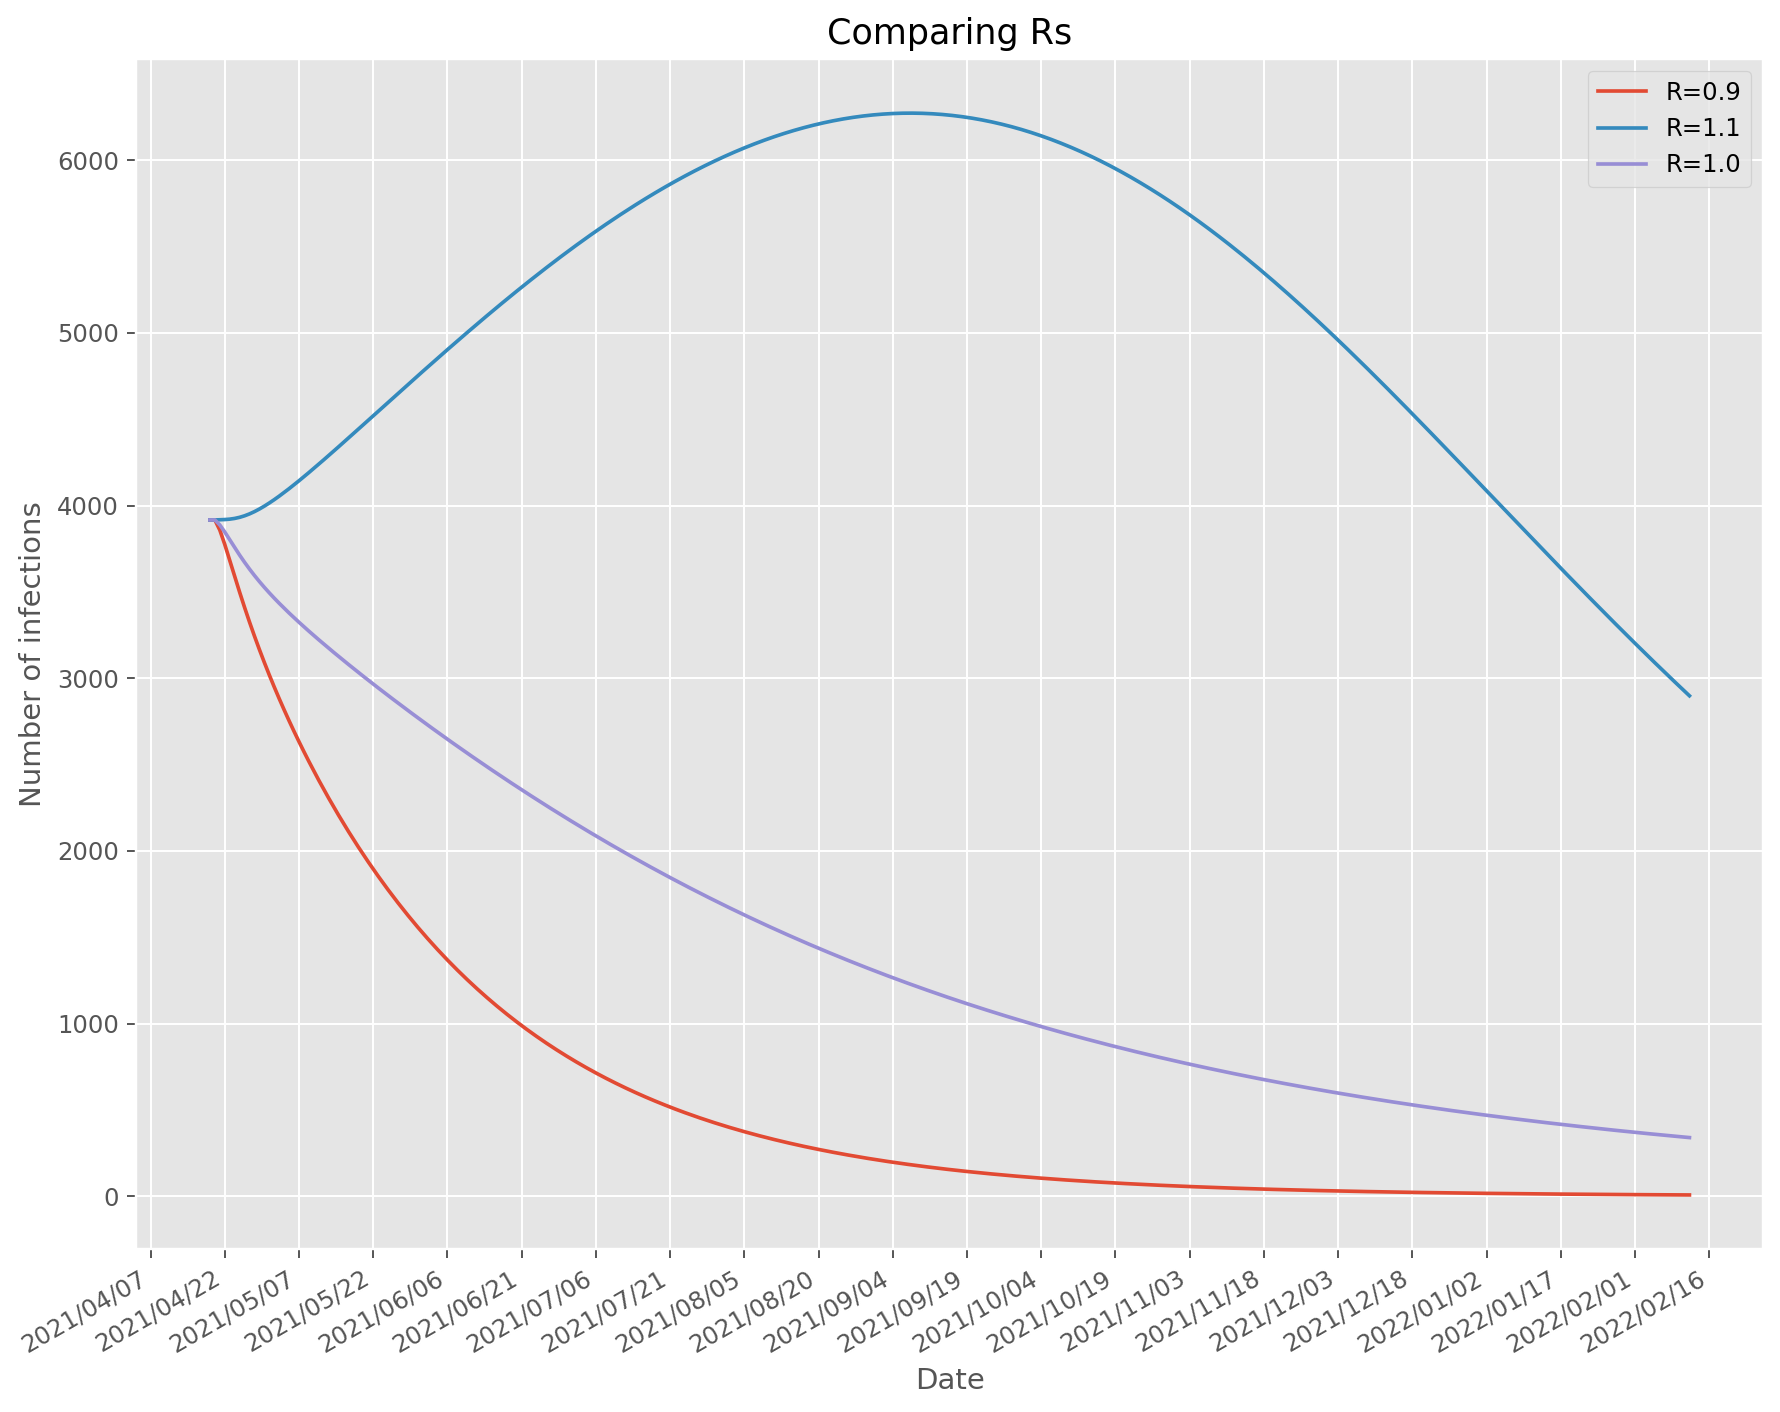

In [6]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = compare_rs_curves(ax, t0, T, r_infs)

fig.autofmt_xdate()

In [7]:
init_vacc = False
mob_av, beta_gh, pop_erva_hat, age_er, rho = get_model_parameters(number_age_groups, num_ervas, erva_pop_file, init_vacc, t0)
r_infs = get_infections_r_eff(T, t0, mob_av, beta_gh, pop_erva_hat, age_er, 0.9, 1.1, 1.0)

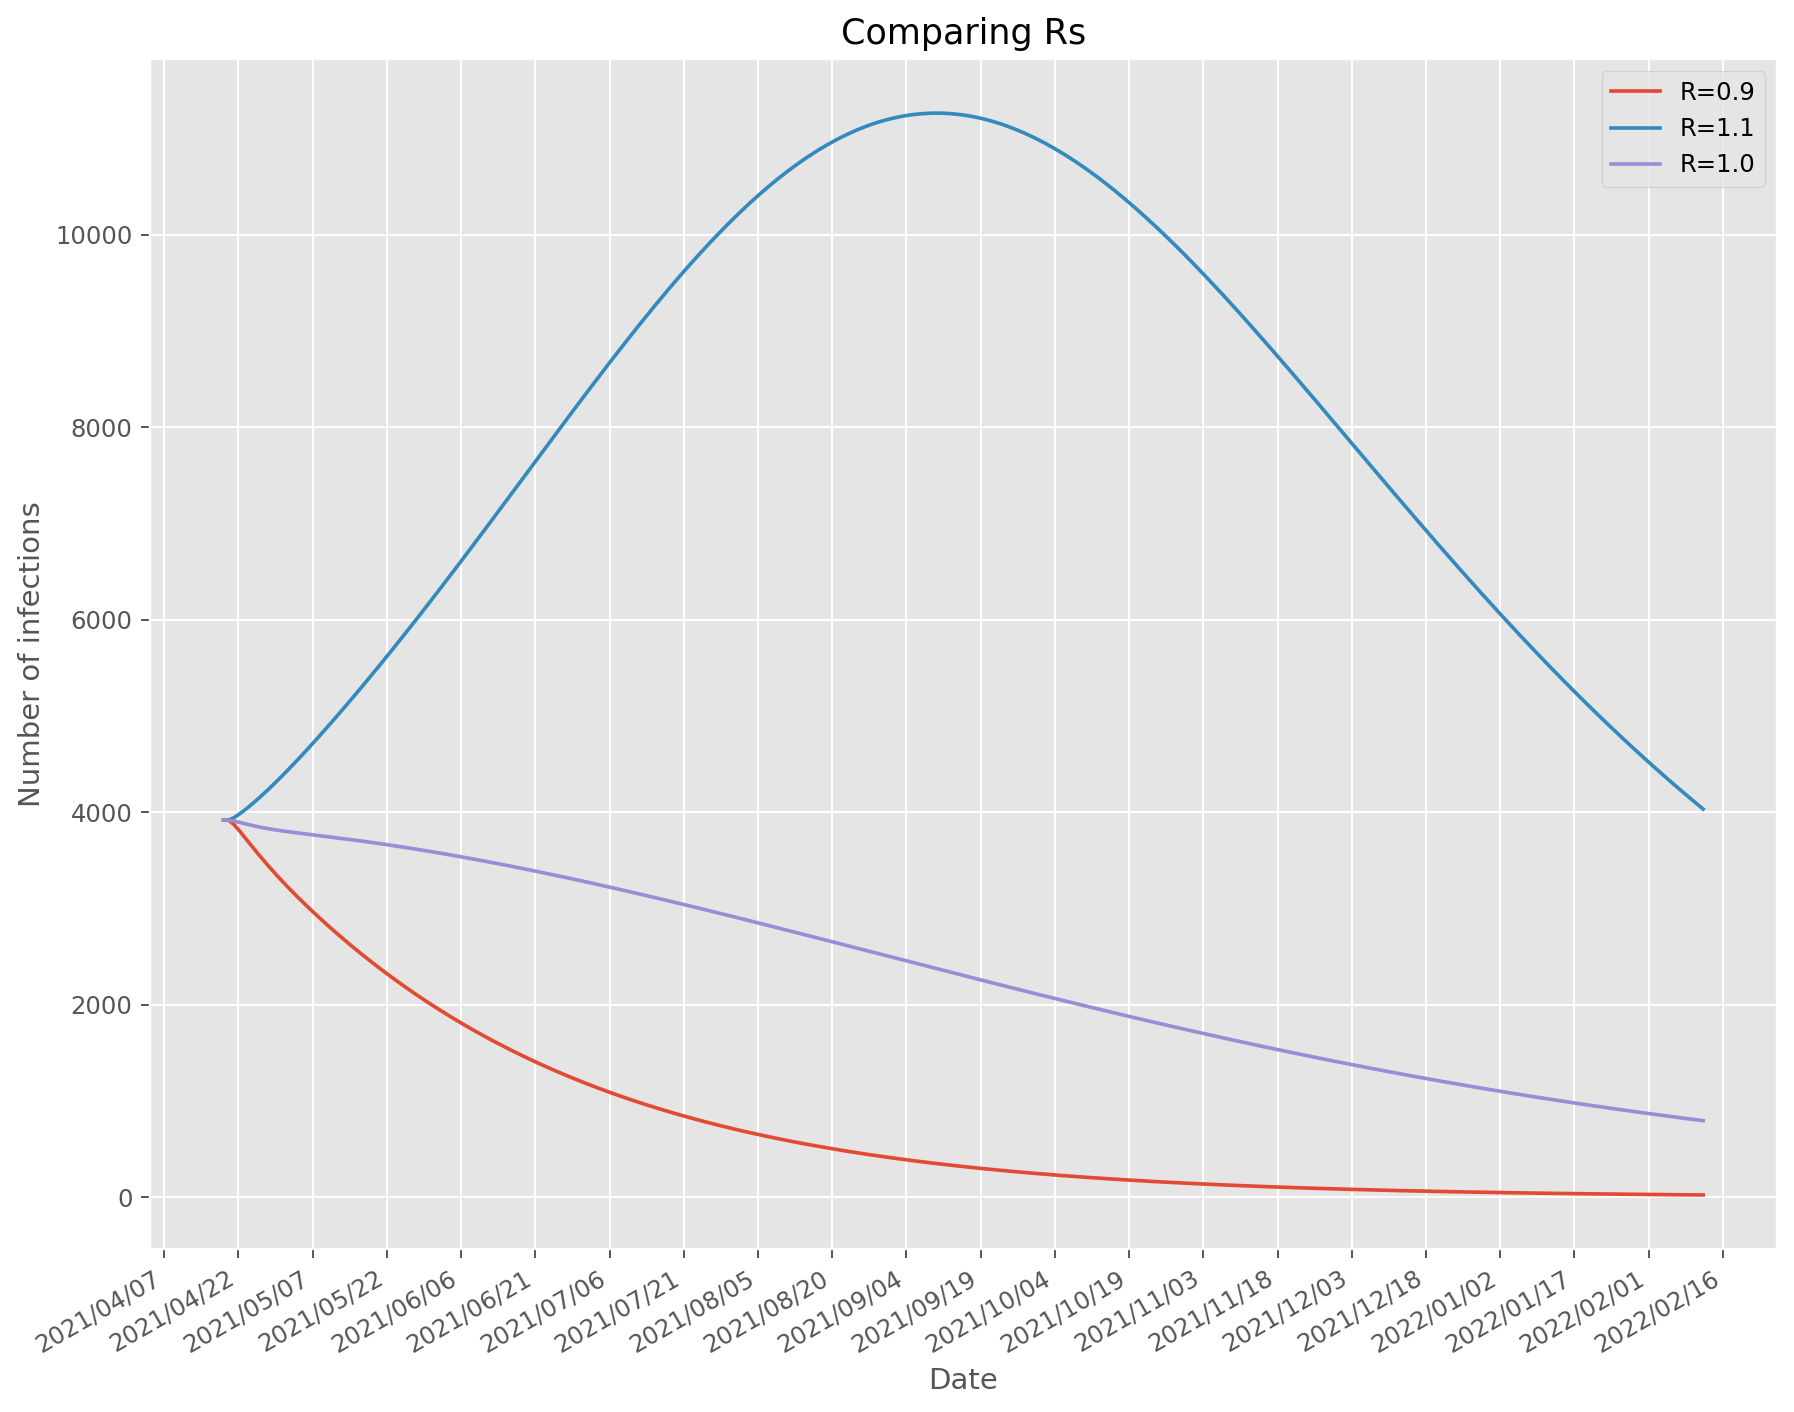

In [8]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = compare_rs_curves(ax, t0, T, r_infs)

fig.autofmt_xdate()

In [9]:
# T = 400
# policy = 'no_vacc'
# rs = np.linspace(0.9, 1.3, 100)
# total_rs = len(rs)
# print('rho: %f' % (rho, ))

# best_r = None
# best_beta = None
# best_d = np.inf
# for i, r in enumerate(rs):
#     beta = r/rho
#     _, _, _, _, I_try, _, _ = forward_integration(u, mob_av, beta, beta_gh, T, pop_erva_hat, age_er, t0, policy)

#     age_er_prop = age_er.T
#     age_er_prop = age_er_prop[:, :, np.newaxis]
#     i_real = I_try*age_er_prop
#     i_real_tot = i_real.sum(axis=1)
#     i_real_tot = i_real_tot.sum(axis=0)
    
#     first_i = i_real_tot[0]
    
#     distance = np.sqrt(np.sum((first_i - i_real_tot)**2))
#     if distance < best_d:
#         best_d = distance
#         best_beta = beta
#         best_r = r
    
#     print('Finished %s/%s. Best R: %f. Best beta: %f. Best distance: %f. Distance: %f' % (i+1, total_rs, best_r, best_beta, best_d, distance), end='\r')